In [1]:
import os
import pandas as pd

folder_path = 'data/'

In [2]:
teams_df = pd.read_csv(os.path.join(folder_path, 'teams.csv'))

In [3]:
def clean_teams_table(df):
    # Drop column: 'lgID', 'franchID', 'divID', 'seeded'
    df = df.drop(columns=['lgID', 'franchID', 'divID', 'seeded'])
    df = df.sort_values(['year'])
    # Change the Y to 1 and N to 0 in the playoff column
    df['playoff'] = df['playoff'].replace({'Y': 1, 'N': 0})
    # change the conference column to 1 for East and 0 for West
    df['confID'] = df['confID'].replace({'EA': 1, 'WE': 0})
    # In the firstRound semis and finals columns, replace W with 1, L with 0, and null with -1
    columns_to_replace = ['firstRound', 'semis', 'finals']
    df[columns_to_replace] = df[columns_to_replace].replace({'W': 1, 'L': 0}).fillna(-1)
    # Drop column: 'name'
    df = df.drop(columns=['name'])
    # Drop columns: 'opptmORB', 'tmTRB', 'tmDRB', 'tmORB' , 'opptmDRB', 'opptmTRB'
    df = df.drop(columns=['opptmORB', 'tmTRB', 'tmDRB', 'tmORB' , 'opptmDRB', 'opptmTRB'])
    # Drop column: 'arena'
    df = df.drop(columns=['arena'])
    # Win Rates
    df['win_rate'] = (df['won'] / df['GP'] * 100).round(2)
    df['homeWin_rate'] = (df['homeW'] / (df['homeW'] + df['homeL']) * 100).round(2)
    df['awayWin_rate'] = (df['awayW'] / (df['awayW'] + df['awayL']) * 100).round(2)
    df['confW_rate'] = (df['confW'] / (df['confW'] + df['confL']) * 100).round(2)
    # Drop columns: 'won', 'lost' and 7 other columns
    df = df.drop(columns=['won', 'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'GP'])
    return df

df_clean = clean_teams_table(teams_df.copy())
df_clean.head()

/tmp/ipykernel_1512478/3748898563.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['playoff'] = df['playoff'].replace({'Y': 1, 'N': 0})
/tmp/ipykernel_1512478/3748898563.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['confID'] = df['confID'].replace({'EA': 1, 'WE': 0})
/tmp/ipykernel_1512478/3748898563.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future beh

,year,tmID,confID,rank,playoff,firstRound,semis,finals,o_fgm,o_fga,...,d_stl,d_to,d_blk,d_pts,min,attend,win_rate,homeWin_rate,awayWin_rate,confW_rate
13,1,CLE,1,2,1,1.0,0.0,-1.0,809,1828,...,305,552,95,2122,6500,137532,53.12,81.25,25.00,61.90
119,1,SEA,0,8,0,-1.0,-1.0,-1.0,667,1740,...,284,529,123,2171,6475,142594,18.75,25.00,12.50,19.05
99,1,POR,0,7,0,-1.0,-1.0,-1.0,761,1828,...,277,531,130,2303,6525,133076,31.25,37.50,25.00,19.05
102,1,SAC,0,3,1,0.0,-1.0,-1.0,876,1993,...,226,524,116,2176,6400,126841,65.62,81.25,50.00,61.90
89,1,PHO,0,4,1,0.0,-1.0,-1.0,803,1800,...,224,531,91,2102,6425,161075,62.50,68.75,56.25,52.38


In [4]:
# Offensive metrics
df_clean['FGE'] = df_clean['o_fgm'] / df_clean['o_fga']
df_clean['FTE'] = df_clean['o_ftm'] / df_clean['o_fta']
df_clean['3PE'] = df_clean['o_3pm'] / df_clean['o_3pa']
df_clean['OREB%'] = df_clean['o_oreb'] / (df_clean['o_oreb'] + df_clean['d_dreb'])
df_clean['AST/TO'] = df_clean['o_asts'] / (df_clean['o_to'] + 1e-9)  # To avoid division by zero

# Defensive metrics (inverted for opponent metrics where lower values are better)
df_clean['Opp_FGE'] = 1 - (df_clean['d_fgm'] / df_clean['d_fga'])
df_clean['Opp_FTE'] = 1 - (df_clean['d_ftm'] / df_clean['d_fta'])
df_clean['Opp_3PE'] = 1 - (df_clean['d_3pm'] / df_clean['d_3pa'])
df_clean['DREB%'] = df_clean['d_dreb'] / (df_clean['d_dreb'] + df_clean['o_oreb'])
df_clean['TO_Forced'] = df_clean['d_to'] / (df_clean['o_to'] + df_clean['d_to'] + 1e-9)

# Offensive weighted score
df_clean['Offensive_Score'] = (
    0.20 * df_clean['FGE'] +
    0.10 * df_clean['FTE'] +
    0.10 * df_clean['3PE'] +
    0.15 * df_clean['OREB%'] +
    0.15 * df_clean['AST/TO'] +
    0.30 * df_clean['o_pts'] / df_clean['o_pts'].max()  # Normalizing points
)

# Defensive weighted score
df_clean['Defensive_Score'] = (
    0.20 * df_clean['Opp_FGE'] +
    0.10 * df_clean['Opp_FTE'] +
    0.10 * df_clean['Opp_3PE'] +
    0.15 * df_clean['DREB%'] +
    0.15 * df_clean['TO_Forced'] +
    0.30 * (1 - df_clean['d_pts'] / df_clean['d_pts'].max())  # Normalizing points allowed
)

# Overall normalized heuristic score (between 0 and 1)
df_clean['Heuristic_Score'] = (df_clean['Offensive_Score'] + df_clean['Defensive_Score']) / 2

columns_to_drop = [
    'FGE', 'FTE', '3PE', 'OREB%', 'AST/TO',  # Offensive metrics
    'Opp_FGE', 'Opp_FTE', 'Opp_3PE', 'DREB%', 'TO_Forced',  # Defensive metrics
    'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa',
    'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts',
    'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb',
    'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts',
]

df_clean=df_clean.drop(columns=columns_to_drop)
df_clean.head()

,year,tmID,confID,rank,playoff,firstRound,semis,finals,min,attend,win_rate,homeWin_rate,awayWin_rate,confW_rate,Offensive_Score,Defensive_Score,Heuristic_Score
13,1,CLE,1,2,1,1.0,0.0,-1.0,6500,137532,53.12,81.25,25.00,61.90,0.609431,0.464088,0.536759
119,1,SEA,0,8,0,-1.0,-1.0,-1.0,6475,142594,18.75,25.00,12.50,19.05,0.498096,0.469512,0.483804
99,1,POR,0,7,0,-1.0,-1.0,-1.0,6525,133076,31.25,37.50,25.00,19.05,0.561561,0.450173,0.505867
102,1,SAC,0,3,1,0.0,-1.0,-1.0,6400,126841,65.62,81.25,50.00,61.90,0.653454,0.463167,0.558310
89,1,PHO,0,4,1,0.0,-1.0,-1.0,6425,161075,62.50,68.75,56.25,52.38,0.619434,0.489219,0.554326


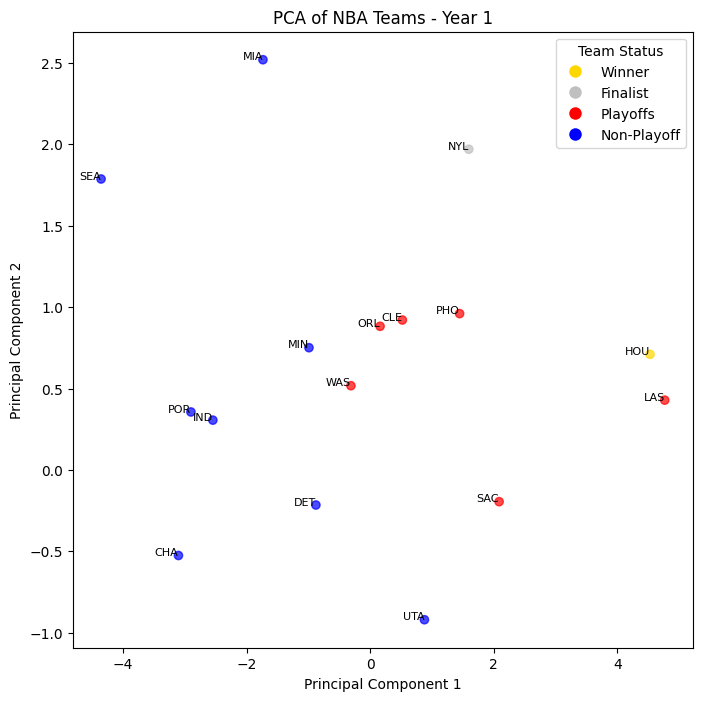

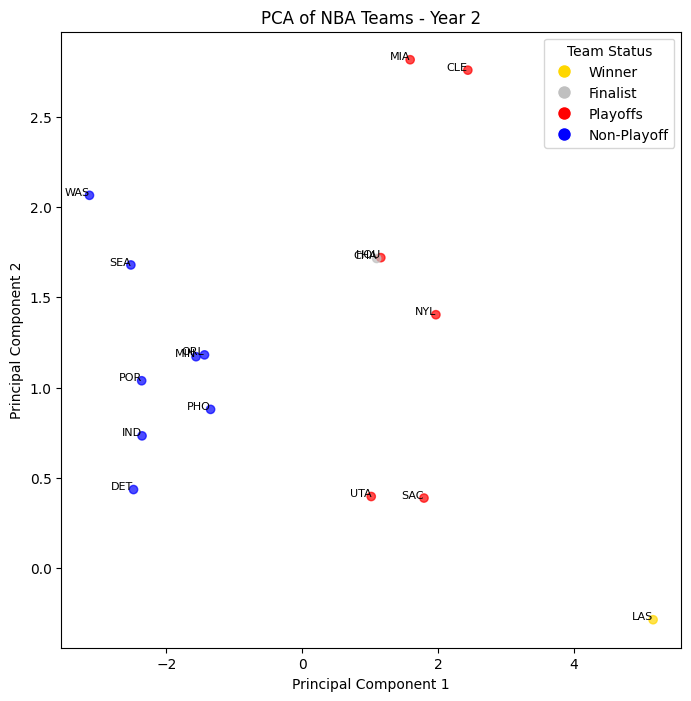

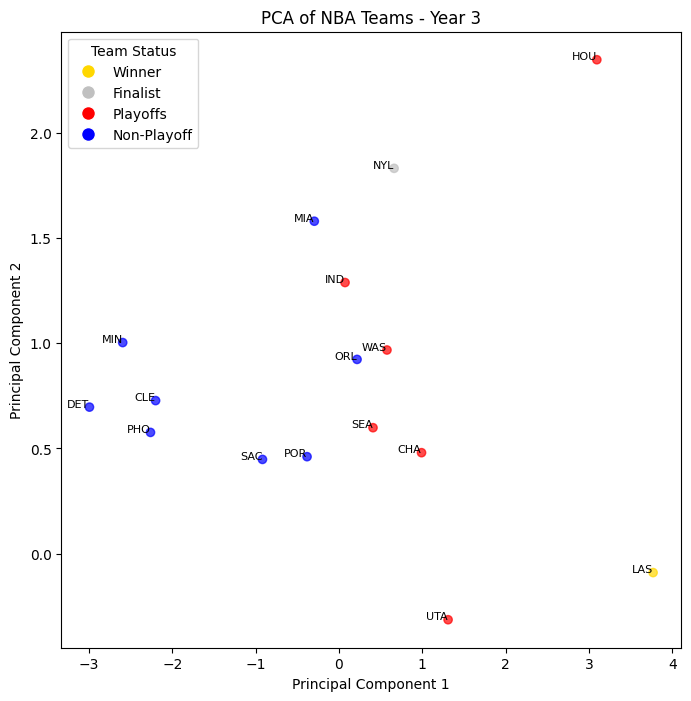

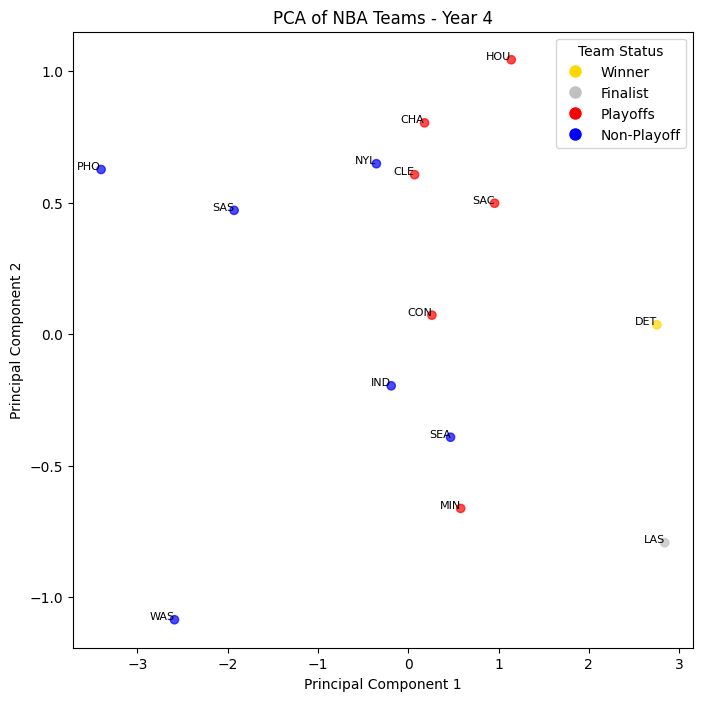

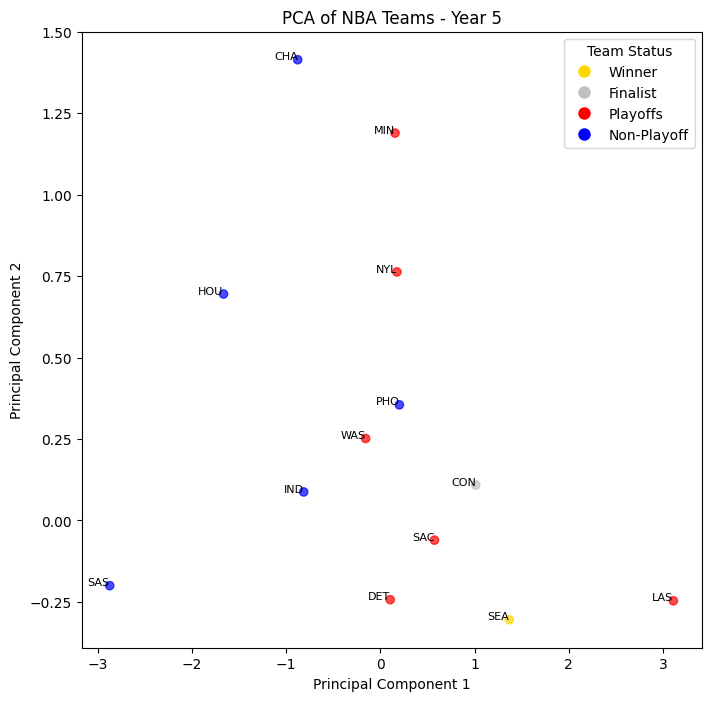

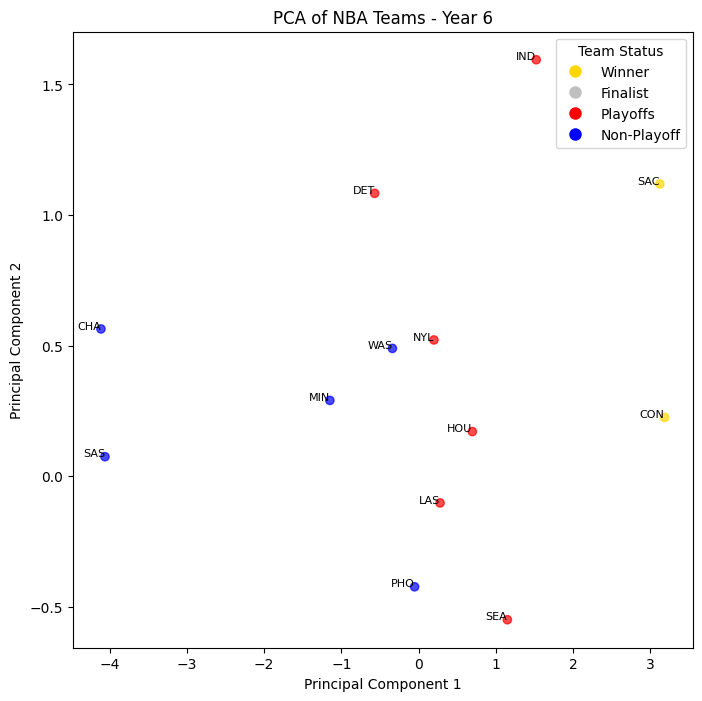

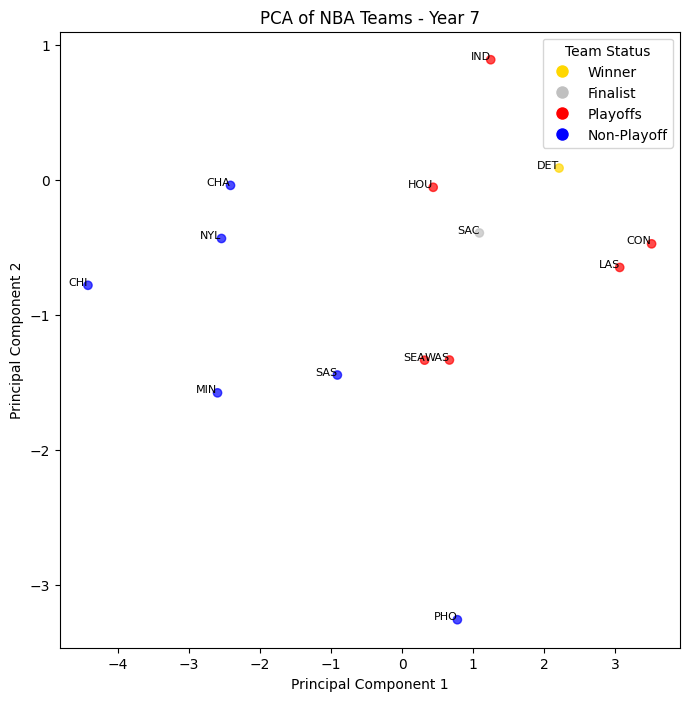

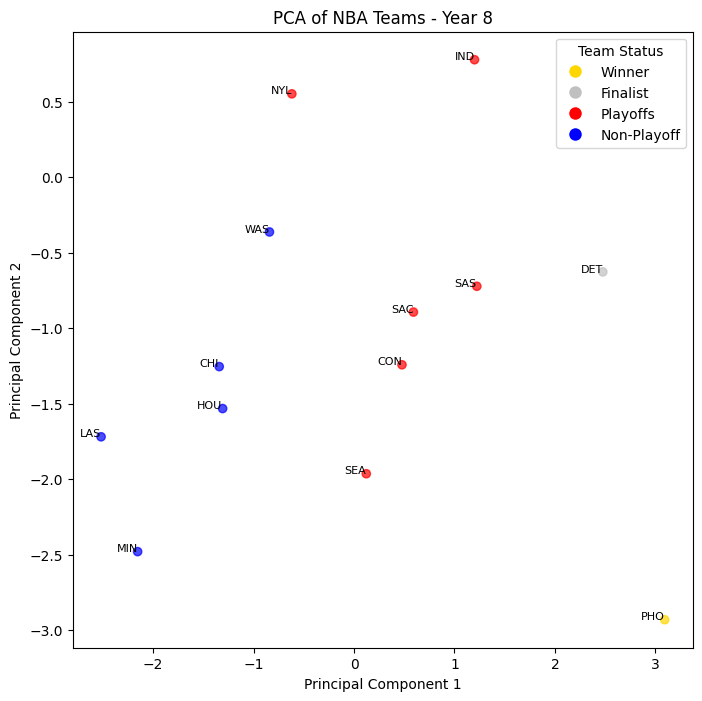

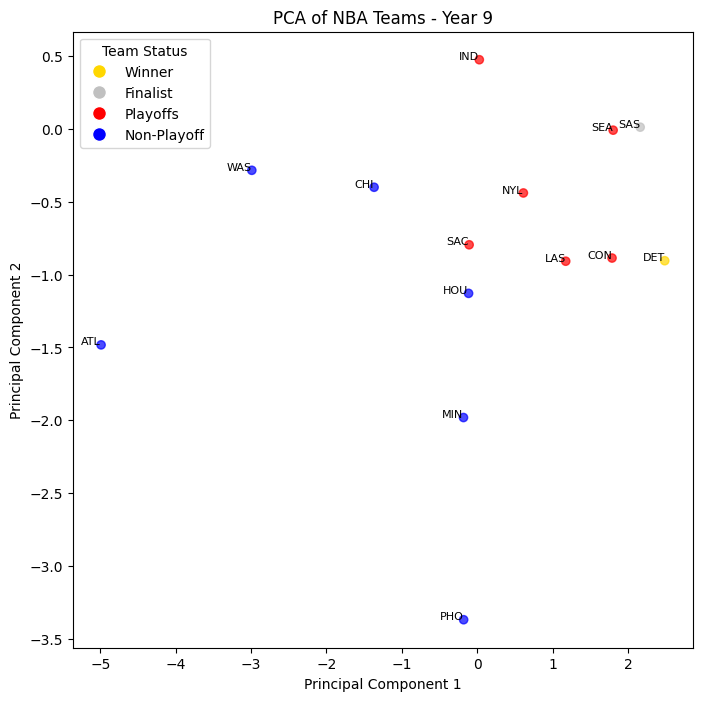

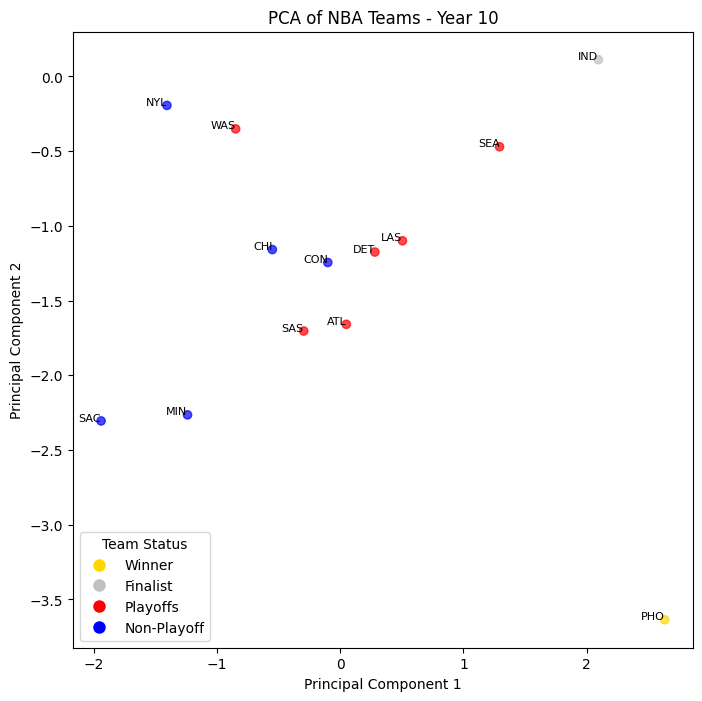

In [5]:
# Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Columns to use for PCA
columns_for_pca = [
    'confID', 'win_rate', 'homeWin_rate', 'awayWin_rate', 'confW_rate',
    'Offensive_Score', 'Defensive_Score'
]

# Standardizing the data
scaler = StandardScaler()
df_clean_scaled = scaler.fit_transform(df_clean[columns_for_pca])

# Applying PCA once on the entire dataset
pca = PCA(n_components=2)
df_clean_pca = pca.fit_transform(df_clean_scaled)

# Adding PCA components to the original DataFrame
df_clean['PCA1'] = df_clean_pca[:, 0]
df_clean['PCA2'] = df_clean_pca[:, 1]

# Get unique years for plotting
unique_years = df_clean['year'].unique()

# Define a color mapping based on playoff and finals status
def get_color(row):
    # First, determine playoff color: red for playoff, blue for non-playoff
    if row['playoff'] == 1:
        color = 'red'  # Playoff teams will be red
    else:
        color = 'blue'  # Non-playoff teams will be blue
    
    # Then, determine if they are in the finals (gold if in finals, silver if not)
    if row['finals'] == 1:
        return 'gold'  # Gold for teams in finals
    elif row['finals'] == 0:
        return 'silver'  # Silver for teams not in finals
    return color

# Apply the color function to each row
df_clean['color'] = df_clean.apply(get_color, axis=1)

# Plotting PCA for each year separately with custom color coding
for year in unique_years:
    df_year = df_clean[df_clean['year'] == year]
    
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        df_year['PCA1'], df_year['PCA2'],
        c=df_year['color'],  # Use the custom color array
        alpha=0.7
    )
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA of NBA Teams - Year {year}')
    
    # Adding tmID labels for each point
    for i, tm_id in enumerate(df_year['tmID']):
        plt.text(df_year['PCA1'].iloc[i], df_year['PCA2'].iloc[i], str(tm_id), fontsize=8, ha='right')
    
    # Adding a legend for each condition
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Winner', markerfacecolor='gold', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Finalist', markerfacecolor='silver', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Playoffs', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Non-Playoff', markerfacecolor='blue', markersize=10)
    ]
    plt.legend(handles=handles, title='Team Status')

    plt.show()


In [6]:
# After fitting PCA as before
pca = PCA(n_components=2)
df_clean_pca = pca.fit_transform(df_clean_scaled)

# Get the principal component loadings
loadings = pca.components_

# Display each principal component with the feature names and their contributions
for i, component in enumerate(loadings):
    print(f"\nPrincipal Component {i+1}")
    for feature, loading in zip(columns_for_pca, component):
        print(f"{feature}: {loading:.4f}")



Principal Component 1
confID: -0.0636
win_rate: 0.5043
homeWin_rate: 0.4444
awayWin_rate: 0.4417
confW_rate: 0.4778
Offensive_Score: 0.3111
Defensive_Score: 0.1546

Principal Component 2
confID: 0.2200
win_rate: 0.0435
homeWin_rate: 0.0859
awayWin_rate: -0.0140
confW_rate: 0.0638
Offensive_Score: -0.6029
Defensive_Score: 0.7580


---

In [7]:
def clean_players_table(df):
    # Drop column: 'firstseason'
    df = df.drop(columns=['firstseason', 'lastseason', 'deathDate'])
    # Extract year from birthDate
    df['birthDate'] = df['birthDate'].str[:4].astype(int)
    return df

df_players = pd.read_csv(os.path.join(folder_path, 'players.csv'))

df_players = clean_players_table(df_players.copy())
df_players.head()

,bioID,pos,height,weight,college,collegeOther,birthDate
0,abrahta01w,C,74.0,190,George Washington,NaN,1975
1,abrossv01w,F,74.0,169,Connecticut,NaN,1980
2,adairje01w,C,76.0,197,George Washington,NaN,1986
3,adamsda01w,F-C,73.0,239,Texas A&M,Jefferson College (JC),1989
4,adamsjo01w,C,75.0,180,New Mexico,NaN,1981


In [8]:
def clean_pteams_data(df):
    # Sort by year, then aggregate by playerID
    df = df.sort_values(by=['year', 'playerID', 'stint'])
    return df

# Loaded variable 'df' from URI: /home/francisco/Desktop/MEIC_1YEAR/ac/WNBA_playoffs_qualification_Predictor/data/players_teams.csv
df_pteams = pd.read_csv(os.path.join(folder_path,'players_teams.csv'))

df_pteams = clean_pteams_data(df_pteams.copy())
df_pteams.head()

,playerID,year,stint,tmID,lgID,GP,GS,minutes,points,oRebounds,...,PostBlocks,PostTurnovers,PostPF,PostfgAttempted,PostfgMade,PostftAttempted,PostftMade,PostthreeAttempted,PostthreeMade,PostDQ
12,aldrima01w,1,0,WAS,WNBA,29,0,272,63,8,...,0,1,3,11,5,8,4,3,0,0
28,anderke01w,1,0,WAS,WNBA,30,9,434,75,12,...,0,4,1,3,1,2,0,0,0,0
31,andrame01w,1,0,CLE,WNBA,32,18,797,265,32,...,3,11,17,33,8,9,5,9,0,0
37,arcaija01w,1,0,HOU,WNBA,32,32,977,268,36,...,0,16,14,47,21,7,6,7,2,0
42,askamma01w,1,0,MIA,WNBA,32,32,869,251,96,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#I have 2 dataframes, df_pteams and df_players, the df_playes have this "bioID	pos	height	weight	college	collegeOther	birthDate" 
# I want to merge that info with the infon in df_pteams on bioID to playerID

df_players_merged = df_pteams.merge(df_players, left_on='playerID', right_on='bioID', how='left')
df_players_merged = df_players_merged.drop(columns=['bioID', 'lgID'])

df_players_merged.head()

# save in data/players_teams_merged.csv
#df_players_merged.to_csv(os.path.join(folder_path, 'players_teams_merged.csv'), index=False)


,playerID,year,stint,tmID,GP,GS,minutes,points,oRebounds,dRebounds,...,PostftMade,PostthreeAttempted,PostthreeMade,PostDQ,pos,height,weight,college,collegeOther,birthDate
0,aldrima01w,1,0,WAS,29,0,272,63,8,16,...,4,3,0,0,G,71.0,153,UNC Charlotte,NaN,1973
1,anderke01w,1,0,WAS,30,9,434,75,12,34,...,0,0,0,0,G,67.0,125,Wisconsin,NaN,1974
2,andrame01w,1,0,CLE,32,18,797,265,32,63,...,5,9,0,0,F,71.0,165,Old Dominion,NaN,1975
3,arcaija01w,1,0,HOU,32,32,977,268,36,83,...,6,7,2,0,G,71.0,147,none,NaN,1969
4,askamma01w,1,0,MIA,32,32,869,251,96,135,...,0,0,0,0,C,77.0,198,none,NaN,1970


In [10]:
# print all the fields in the df_players_merged

df_players_merged.columns

Index(['playerID', 'year', 'stint', 'tmID', 'GP', 'GS', 'minutes', 'points',
       'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks',
       'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade',
       'threeAttempted', 'threeMade', 'dq', 'PostGP', 'PostGS', 'PostMinutes',
       'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds',
       'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF',
       'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade',
       'PostthreeAttempted', 'PostthreeMade', 'PostDQ', 'pos', 'height',
       'weight', 'college', 'collegeOther', 'birthDate'],
      dtype='object')

In [11]:
# print distinct values in the 'pos' column

df_players_merged['pos'].unique()

array(['G', 'F', 'C', 'G-F', 'F-C', 'C-F', 'F-G'], dtype=object)

In [12]:
# Define regular season score calculation
def calculate_regular_season_score(row):
    if 'G' in row['pos'] and 'F' in row['pos']:  # G-F or F-G
        return (0.15 * row['points'] + 0.275 * row['assists'] + 
                0.1 * row['steals'] + 0.175 * row['threeMade'] + 
                0.15 * row['rebounds'] + 0.075 * row['blocks'] - 
                0.1 * row['turnovers'])
    elif 'F' in row['pos'] and 'C' in row['pos']:  # F-C or C-F
        return (0.35 * row['rebounds'] + 0.35 * row['points'] + 
                0.15 * row['blocks'] + 0.075 * row['assists'] - 
                0.05 * row['turnovers'])
    elif 'G' in row['pos']:  # Pure Guard
        return (0.3 * row['points'] + 0.25 * row['assists'] + 
                0.2 * row['steals'] + 0.15 * row['threeMade'] - 
                0.1 * row['turnovers'])
    elif 'F' in row['pos']:  # Pure Forward
        return (0.35 * row['points'] + 0.3 * row['rebounds'] + 
                0.2 * row['assists'] + 0.1 * row['blocks'] - 
                0.05 * row['turnovers'])
    elif 'C' in row['pos']:  # Pure Center
        return (0.4 * row['rebounds'] + 0.35 * row['points'] + 
                0.2 * row['blocks'] - 0.05 * row['turnovers'])
    return 0

# Define postseason score calculation
def calculate_postseason_score(row):
    if row['PostMinutes'] == 0:  # Avoid division by zero
        return 0
    PostPointsPerMinute = row['PostPoints'] / row['PostMinutes']
    PostReboundsPerMinute = row['PostRebounds'] / row['PostMinutes']
    PostAssistsPerMinute = row['PostAssists'] / row['PostMinutes']
    PostStealsPerMinute = row['PostSteals'] / row['PostMinutes']
    PostBlocksPerMinute = row['PostBlocks'] / row['PostMinutes']
    PostTurnoversPerMinute = row['PostTurnovers'] / row['PostMinutes']
    PostThreeMadePerMinute = row['PostthreeMade'] / row['PostMinutes']
    
    if 'G' in row['pos'] and 'F' in row['pos']:  # G-F or F-G
        return (0.15 * PostPointsPerMinute + 0.275 * PostAssistsPerMinute + 
                0.1 * PostStealsPerMinute + 0.175 * PostThreeMadePerMinute + 
                0.15 * PostReboundsPerMinute + 0.075 * PostBlocksPerMinute - 
                0.1 * PostTurnoversPerMinute)
    elif 'F' in row['pos'] and 'C' in row['pos']:  # F-C or C-F
        return (0.35 * PostReboundsPerMinute + 0.35 * PostPointsPerMinute + 
                0.15 * PostBlocksPerMinute + 0.075 * PostAssistsPerMinute - 
                0.05 * PostTurnoversPerMinute)
    elif 'G' in row['pos']:  # Pure Guard
        return (0.3 * PostPointsPerMinute + 0.25 * PostAssistsPerMinute + 
                0.2 * PostStealsPerMinute + 0.15 * PostThreeMadePerMinute - 
                0.1 * PostTurnoversPerMinute)
    elif 'F' in row['pos']:  # Pure Forward
        return (0.35 * PostPointsPerMinute + 0.3 * PostReboundsPerMinute + 
                0.2 * PostAssistsPerMinute + 0.1 * PostBlocksPerMinute - 
                0.05 * PostTurnoversPerMinute)
    elif 'C' in row['pos']:  # Pure Center
        return (0.4 * PostReboundsPerMinute + 0.35 * PostPointsPerMinute + 
                0.2 * PostBlocksPerMinute - 0.05 * PostTurnoversPerMinute)
    return 0

# Apply the score calculations
df_posScore = df_players_merged.copy()
df_posScore['RegularScore'] = df_players_merged.apply(calculate_regular_season_score, axis=1)
df_posScore['PostseasonScore'] = df_players_merged.apply(calculate_postseason_score, axis=1)

# View the results
print(df_posScore[['playerID', 'pos', 'RegularScore', 'PostseasonScore']])


        playerID pos  RegularScore  PostseasonScore
0     aldrima01w   G         25.90         0.123469
1     anderke01w   G         42.00         0.048333
2     andrame01w   F        134.00         0.090361
3     arcaija01w   G         99.85         0.093035
4     askamma01w   C        182.00         0.000000
...          ...  ..           ...              ...
1871  wyckobr01w   F         59.10         0.000000
1872  youngso01w   F        283.80         0.273437
1873  youngta01w   F         15.35         0.000000
1874  youngta01w   F         27.75         0.000000
1875  zellosh01w   G        137.25         0.196207

[1876 rows x 4 columns]


In [13]:
# I want to put it also in this dataframe the score of the team on that stint, that should be like a mean of the players in that team

# Define a function to calculate the team score

def calculate_team_score(row):
    team_players = df_posScore[(df_posScore['tmID'] == row['tmID']) & (df_posScore['year'] == row['year'])]
    return team_players['RegularScore'].mean()

# Apply the team score calculation
df_players_teamScore = df_posScore.copy()
df_players_teamScore['TeamScore'] = df_posScore.apply(calculate_team_score, axis=1)

# View the results
print(df_players_teamScore[['playerID', 'pos', 'RegularScore', 'PostseasonScore', 'TeamScore']])

        playerID pos  RegularScore  PostseasonScore   TeamScore
0     aldrima01w   G         25.90         0.123469   82.794231
1     anderke01w   G         42.00         0.048333   82.794231
2     andrame01w   F        134.00         0.090361   81.709615
3     arcaija01w   G         99.85         0.093035   86.637500
4     askamma01w   C        182.00         0.000000   62.330769
...          ...  ..           ...              ...         ...
1871  wyckobr01w   F         59.10         0.000000   97.552083
1872  youngso01w   F        283.80         0.273437  123.322222
1873  youngta01w   F         15.35         0.000000  103.684615
1874  youngta01w   F         27.75         0.000000   97.552083
1875  zellosh01w   G        137.25         0.196207   61.476389

[1876 rows x 5 columns]


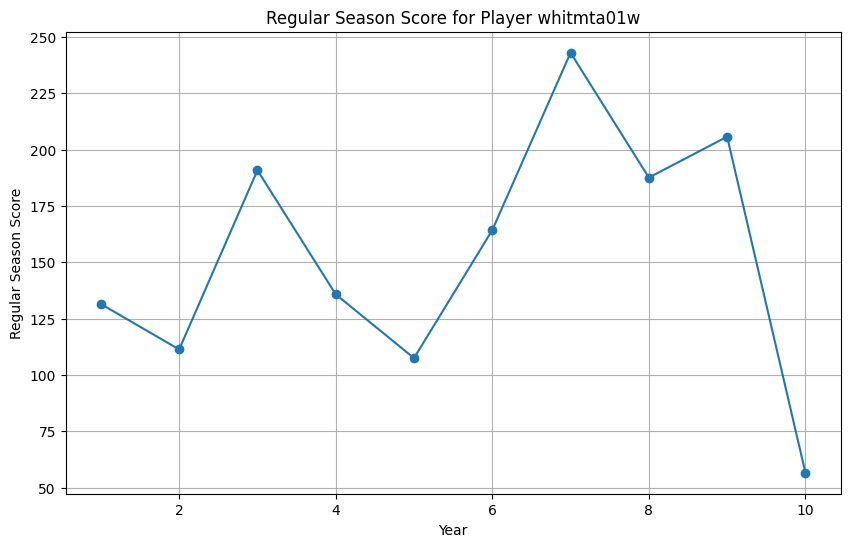

In [14]:
def plot_player_regular_score(player_id):
    # Filter the data for the given player
    df_player = df_players_teamScore[df_players_teamScore['playerID'] == player_id]

    # Plot the regular score for each year
    plt.figure(figsize=(10, 6))
    plt.plot(df_player['year'], df_player['RegularScore'], marker='o')
    plt.xlabel('Year')
    plt.ylabel('Regular Season Score')
    plt.title(f'Regular Season Score for Player {player_id}')
    plt.grid(True)
    plt.show()

# Example usage
plot_player_regular_score('whitmta01w')

In [15]:
# print the players with most years in the league sorted by highest score

# Group by playerID and count the number of unique years
df_years = df_players_teamScore.groupby('playerID')['year'].nunique()
# Sort the players by the number of years
df_years = df_years.sort_values(ascending=False)
# Get the top 10 players with the most years
top_players = df_years.head(10)
# Display the top players
print(top_players)

playerID
lennobe01w    10
johnssh01w    10
cantydo01w    10
whitmta01w    10
melvich01w    10
hammobe01w    10
beviltu01w    10
mcwilta01w    10
smithka01w    10
johnsvi01w    10
Name: year, dtype: int64


In [16]:
# I want like the difference between a player score and the team score, so I can see if the player is above or below the team average

# Calculate the difference between player score and team score
df_players_teamScore['ScoreDiff'] = df_players_teamScore['RegularScore'] - df_players_teamScore['TeamScore']

# View the results
print(df_players_teamScore[['playerID', 'pos', 'RegularScore', 'PostseasonScore', 'TeamScore', 'ScoreDiff']])

        playerID pos  RegularScore  PostseasonScore   TeamScore   ScoreDiff
0     aldrima01w   G         25.90         0.123469   82.794231  -56.894231
1     anderke01w   G         42.00         0.048333   82.794231  -40.794231
2     andrame01w   F        134.00         0.090361   81.709615   52.290385
3     arcaija01w   G         99.85         0.093035   86.637500   13.212500
4     askamma01w   C        182.00         0.000000   62.330769  119.669231
...          ...  ..           ...              ...         ...         ...
1871  wyckobr01w   F         59.10         0.000000   97.552083  -38.452083
1872  youngso01w   F        283.80         0.273437  123.322222  160.477778
1873  youngta01w   F         15.35         0.000000  103.684615  -88.334615
1874  youngta01w   F         27.75         0.000000   97.552083  -69.802083
1875  zellosh01w   G        137.25         0.196207   61.476389   75.773611

[1876 rows x 6 columns]


In [17]:
df_players_teamScore = df_players_teamScore.drop(columns=['oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 
                                                            'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 
                                                            'threeAttempted', 'threeMade', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 
                                                            'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds', 
                                                            'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 
                                                            'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade', 
                                                            'PostthreeAttempted', 'PostthreeMade', 'PostDQ'])

df_players_teamScore.columns

Index(['playerID', 'year', 'stint', 'tmID', 'GP', 'GS', 'minutes', 'points',
       'pos', 'height', 'weight', 'college', 'collegeOther', 'birthDate',
       'RegularScore', 'PostseasonScore', 'TeamScore', 'ScoreDiff'],
      dtype='object')

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

# Load data
df = df_players_teamScore

# === Feature Engineering ===

# Rolling averages for past performance
df['avg_points_last_3_years'] = df.groupby('playerID')['points'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df['avg_minutes_last_3_years'] = df.groupby('playerID')['minutes'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df['team_avg_score'] = df.groupby('tmID')['TeamScore'].transform('mean')

# Fill missing or invalid values
df = df.fillna(0)

# === Encode 'pos' for the Model ===
# Use one-hot encoding for the position field
pos_encoder = OneHotEncoder(sparse_output=False)
pos_encoded = pos_encoder.fit_transform(df[['pos']])
pos_encoded_df = pd.DataFrame(pos_encoded, columns=pos_encoder.get_feature_names_out(['pos']))
df = pd.concat([df, pos_encoded_df], axis=1)

# === Model Training ===

# Define features and target
# Exclude 'age' to prevent bias in predictions, include position (encoded) and team score
features = ['avg_points_last_3_years', 'avg_minutes_last_3_years', 'team_avg_score',
            'height', 'weight', 'GP', 'GS', 'stint', 'year'] + list(pos_encoded_df.columns)
X = df[features]
y = df['RegularScore']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the entire dataset to create 'predict_score'
df['predict_score'] = model.predict(X)

# Evaluate
from sklearn.metrics import mean_squared_error
y_test_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 480.1316048668548


In [21]:
# put the predict_score in the df_players_teamScore clone

df_predict_score = df_players_teamScore.copy()
df_predict_score['predict_score'] = df['predict_score']

# save in predict_score.csv
df_predict_score.to_csv(os.path.join(folder_path, 'predict_score.csv'), index=False)

In [ ]:
df_predict_score

In [22]:
def calculate_predict_team_score(row):
    team_players = df_predict_score[(df_posScore['tmID'] == row['tmID']) & (df_posScore['year'] == row['year'])]
    return team_players['predict_score'].mean()

# Apply the team score calculation
df_players_teamPredictScore = df_predict_score.copy()
df_players_teamPredictScore['team_predict'] = df_posScore.apply(calculate_predict_team_score, axis=1)


def calculate_teamScore_post(row):
    team_players = df_posScore[(df_posScore['tmID'] == row['tmID']) & (df_posScore['year'] == row['year'])]
    return team_players['PostseasonScore'].mean()

# Apply the team score calculation
df_players_teamPredictScore['team_post'] = df_posScore.apply(calculate_teamScore_post, axis=1)

In [ ]:
df_players_teamPredictScore.columns

Index(['playerID', 'year', 'stint', 'tmID', 'GP', 'GS', 'minutes', 'points',
       'pos', 'height', 'weight', 'college', 'collegeOther', 'birthDate',
       'RegularScore', 'PostseasonScore', 'TeamScore', 'ScoreDiff',
       'avg_points_last_3_years', 'avg_minutes_last_3_years', 'team_avg_score',
       'predict_score', 'team_predict', 'team_post'],
      dtype='object')

In [ ]:
df_clean.columns

Index(['year', 'tmID', 'confID', 'rank', 'playoff', 'firstRound', 'semis',
       'finals', 'min', 'attend', 'win_rate', 'homeWin_rate', 'awayWin_rate',
       'confW_rate', 'Offensive_Score', 'Defensive_Score', 'Heuristic_Score',
       'PCA1', 'PCA2', 'color'],
      dtype='object')

In [ ]:
df_players_teamPredictScore = df_players_teamPredictScore[df_players_teamPredictScore['stint'] != 3]

In [25]:
# Create a copy and apply weights
df_players_teamPredictScoreOP = df_players_teamPredictScore.copy()
df_players_teamPredictScoreOP['weight'] = df_players_teamPredictScoreOP['stint'].map({0: 1, 1: 0.5, 2: 0.5})

# Group by year and tmID, calculate weighted mean for each field separately
weighted_means = (
    df_players_teamPredictScoreOP
    .groupby(['year', 'tmID'])
    .apply(lambda group: pd.Series({
        'team_predict_mean': (group['team_predict'] * group['weight']).sum() / group['weight'].sum(),
        'team_post_mean': (group['team_post'] * group['weight']).sum() / group['weight'].sum(),
        'TeamScore_mean': (group['TeamScore'] * group['weight']).sum() / group['weight'].sum(),
    }))
    .reset_index()
)

# Merge the result back into df_clean
df_team_players = df_clean.copy()
df_team_players.drop(columns=['PCA1', 'PCA2'], inplace=True)
df_team_players = df_team_players.merge(weighted_means, on=['year', 'tmID'], how='left')

# Inspect results
print(df_team_players.columns)
df_team_players.head()

Index(['year', 'tmID', 'confID', 'rank', 'playoff', 'firstRound', 'semis',
       'finals', 'min', 'attend', 'win_rate', 'homeWin_rate', 'awayWin_rate',
       'confW_rate', 'Offensive_Score', 'Defensive_Score', 'Heuristic_Score',
       'color', 'team_predict_mean', 'team_post_mean', 'TeamScore_mean'],
      dtype='object')


/tmp/ipykernel_1512478/900142798.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


,year,tmID,confID,rank,playoff,firstRound,semis,finals,min,attend,...,homeWin_rate,awayWin_rate,confW_rate,Offensive_Score,Defensive_Score,Heuristic_Score,color,team_predict_mean,team_post_mean,TeamScore_mean
0,1,CLE,1,2,1,1.0,0.0,-1.0,6500,137532,...,81.25,25.00,61.90,0.609431,0.464088,0.536759,red,80.946250,0.160087,81.709615
1,1,SEA,0,8,0,-1.0,-1.0,-1.0,6475,142594,...,25.00,12.50,19.05,0.498096,0.469512,0.483804,blue,64.142893,0.000000,61.342857
2,1,POR,0,7,0,-1.0,-1.0,-1.0,6525,133076,...,37.50,25.00,19.05,0.561561,0.450173,0.505867,blue,84.661146,0.000000,84.037500
3,1,SAC,0,3,1,0.0,-1.0,-1.0,6400,126841,...,81.25,50.00,61.90,0.653454,0.463167,0.558310,red,91.463250,0.131097,89.570833
4,1,PHO,0,4,1,0.0,-1.0,-1.0,6425,161075,...,68.75,56.25,52.38,0.619434,0.489219,0.554326,red,78.463054,0.097993,77.451786


In [ ]:
df_players_teamPredictScoreOP

,playerID,year,stint,tmID,GP,GS,minutes,points,pos,height,...,RegularScore,PostseasonScore,TeamScore,ScoreDiff,avg_points_last_3_years,avg_minutes_last_3_years,team_avg_score,predict_score,team_predict,team_post
0,aldrima01w,1,0,WAS,29,0,272,63,G,71.0,...,25.90,0.123469,82.794231,-56.894231,63.000000,272.000000,80.001667,29.36575,82.794231,0.088193
1,anderke01w,1,0,WAS,30,9,434,75,G,67.0,...,42.00,0.048333,82.794231,-40.794231,75.000000,434.000000,80.001667,42.18025,82.794231,0.088193
2,andrame01w,1,0,CLE,32,18,797,265,F,71.0,...,134.00,0.090361,81.709615,52.290385,265.000000,797.000000,80.626923,125.26000,81.709615,0.160087
3,arcaija01w,1,0,HOU,32,32,977,268,G,71.0,...,99.85,0.093035,86.637500,13.212500,268.000000,977.000000,77.390042,108.79350,86.637500,0.102744
4,askamma01w,1,0,MIA,32,32,869,251,C,77.0,...,182.00,0.000000,62.330769,119.669231,251.000000,869.000000,64.579375,178.37125,62.330769,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,wyckobr01w,10,0,CHI,27,23,531,83,F,73.0,...,59.10,0.000000,97.552083,-38.452083,85.333333,548.333333,83.773148,74.98275,97.552083,0.000000
1872,youngso01w,10,0,SAS,33,33,1113,600,F,73.0,...,283.80,0.273437,123.322222,160.477778,576.333333,1091.000000,89.708228,287.43025,123.322222,0.155191
1873,youngta01w,10,1,ATL,11,0,73,30,F,74.0,...,15.35,0.000000,103.684615,-88.334615,135.000000,409.000000,88.403704,16.07425,103.684615,0.133006
1874,youngta01w,10,2,CHI,10,6,129,50,F,74.0,...,27.75,0.000000,97.552083,-69.802083,106.666667,315.666667,83.773148,33.08350,97.552083,0.000000


In [26]:
# Function to calculate last 3 years' history
def calculate_last_3_years_history(df):
    df['last_3_years_history'] = None  # Initialize the column
    for tmID, group in df.groupby('tmID'):
        group = group.sort_values('year')  # Sort by year
        scores = []
        
        for i in range(len(group)):
            # Calculate the average score for the current and previous years
            num_years = min(i + 1, 3)  # Max years is 3
            last_years = group.iloc[max(0, i - num_years + 1):i + 1]
            avg_score = last_years.apply(
                lambda row: (row['Heuristic_Score'] + row['TeamScore_mean']) / 2, axis=1
            ).mean()
            scores.append(avg_score)
        
        # Assign scores back to the DataFrame
        df.loc[group.index, 'last_3_years_history'] = scores

    return df

# Apply the function
df_team_players = calculate_last_3_years_history(df_team_players)

In [27]:

def clean_coaches_data(df):
    # Drop column: 'lgID'
    df = df.drop(columns=['lgID'])
    # Sort by column: 'year' (ascending)
    df = df.sort_values(['year', 'stint', 'tmID'])
    # Calculate win_rate and post_win_rate
    df['win_rate'] = (df['won'] / (df['won'] + df['lost'])) * 100
    df['post_win_rate'] = 0
    df.loc[(df['post_wins'] != 0) | (df['post_losses'] != 0), 'post_win_rate'] = (df['post_wins'] / (df['post_wins'] + df['post_losses'])) * 100
    # Calculate mean win_rate and post_win_rate for the past 5 years
    df['mean_win_rate'] = df.groupby('coachID')['win_rate'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    df['mean_post_win_rate'] = df.groupby('coachID')['post_win_rate'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    return df

# Loaded variable 'df' from URI: /home/francisco/Desktop/MEIC_1YEAR/ac/WNBA_playoffs_qualification_Predictor/data/coaches.csv
df_coaches = pd.read_csv(os.path.join(folder_path, 'coaches.csv'))

df_coaches = clean_coaches_data(df_coaches.copy())
df_coaches.head()

/tmp/ipykernel_1512478/3323090209.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 50.         100.          50.          57.14285714  33.33333333
   0.           0.           0.          50.          33.33333333
   0.          85.71428571  33.33333333  50.          60.
   0.           0.          33.33333333  33.33333333 100.
  50.           0.          40.          60.           0.
  33.33333333  50.          75.          33.33333333  55.55555556
  33.33333333  50.          62.5         33.33333333   0.
  50.          75.          33.33333333  33.33333333  33.33333333
  40.          62.5          0.          40.          50.
   0.          87.5         33.33333333   0.          60.
  70.           0.           0.          40.          66.66666667
  33.33333333   0.          33.33333333  54.54545455  50.
  33.33333333  77.77777778  33.33333333  40.           0.
  33.33333333  77.77777778  33.333333

,coachID,year,tmID,stint,won,lost,post_wins,post_losses,win_rate,post_win_rate,mean_win_rate,mean_post_win_rate
67,dunntr01wc,1,CHA,0,8,24,0,0,25.000,0.0,25.000,0.0
82,hugheda99w,1,CLE,0,17,15,3,3,53.125,50.0,53.125,50.0
106,liebena01w,1,DET,0,14,18,0,0,43.750,0.0,43.750,0.0
26,chancva99w,1,HOU,0,27,5,6,0,84.375,100.0,84.375,100.0
53,donovan99w,1,IND,0,9,23,0,0,28.125,0.0,28.125,0.0


In [31]:
# Create a copy and apply weights
df_coachesOP = df_coaches.copy()
df_coachesOP['weight'] = df_coachesOP['stint'].map({0: 1, 1: 0.5, 2: 0.5})

# Group by year and tmID, calculate weighted mean for each field separately
weighted_means = (
    df_coachesOP
    .groupby(['year', 'tmID'])
    .apply(lambda group: pd.Series({
        'coaches_win_rate': (group['win_rate'] * group['weight']).sum() / group['weight'].sum(),
        'coaches_post': (group['post_win_rate'] * group['weight']).sum() / group['weight'].sum(),
        'coaches_history': (group['mean_win_rate'] * group['weight']).sum() / group['weight'].sum(),
        'coaches_history_pos': (group['mean_post_win_rate'] * group['weight']).sum() / group['weight'].sum(),
    }))
    .reset_index()
)

# Merge the result back into df_clean
df_final = df_team_players.copy()
df_final = df_final.merge(weighted_means, on=['year', 'tmID'], how='left')

# Inspect results
print(df_final.columns)
df_final.head()


Index(['year', 'tmID', 'confID', 'rank', 'playoff', 'firstRound', 'semis',
       'finals', 'min', 'attend', 'win_rate', 'homeWin_rate', 'awayWin_rate',
       'confW_rate', 'Offensive_Score', 'Defensive_Score', 'Heuristic_Score',
       'color', 'team_predict_mean', 'team_post_mean', 'TeamScore_mean',
       'last_3_years_history', 'coaches_win_rate', 'coaches_post',
       'coaches_history', 'coaches_history_pos'],
      dtype='object')


/tmp/ipykernel_1512478/2759194728.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


,year,tmID,confID,rank,playoff,firstRound,semis,finals,min,attend,...,Heuristic_Score,color,team_predict_mean,team_post_mean,TeamScore_mean,last_3_years_history,coaches_win_rate,coaches_post,coaches_history,coaches_history_pos
0,1,CLE,1,2,1,1.0,0.0,-1.0,6500,137532,...,0.536759,red,80.946250,0.160087,81.709615,41.123187,53.125,50.0,53.125,50.0
1,1,SEA,0,8,0,-1.0,-1.0,-1.0,6475,142594,...,0.483804,blue,64.142893,0.000000,61.342857,30.913331,18.750,0.0,18.750,0.0
2,1,POR,0,7,0,-1.0,-1.0,-1.0,6525,133076,...,0.505867,blue,84.661146,0.000000,84.037500,42.271683,31.250,0.0,31.250,0.0
3,1,SAC,0,3,1,0.0,-1.0,-1.0,6400,126841,...,0.558310,red,91.463250,0.131097,89.570833,45.064572,65.625,0.0,65.625,0.0
4,1,PHO,0,4,1,0.0,-1.0,-1.0,6425,161075,...,0.554326,red,78.463054,0.097993,77.451786,39.003056,62.500,0.0,62.500,0.0


In [36]:
df_final = df_final.sort_values(['tmID', 'year'])

df_final['playoff_next_season'] = df_final.groupby('tmID')['playoff'].shift(-1)

df_final['playoff_next_season'] = df_final.apply(
    lambda row: row['playoff_next_season'] if row['year'] == 10 else (0 if pd.isna(row['playoff_next_season']) else row['playoff_next_season']),
    axis=1
)


In [205]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

features = [
    'year', 'tmID', 'confID', 'rank', 'playoff', 'firstRound', 'semis', 'finals', 'min', 'attend',
    'win_rate', 'homeWin_rate', 'awayWin_rate', 'confW_rate', 'Offensive_Score', 'Defensive_Score',
    'Heuristic_Score', 'team_predict_mean', 'team_post_mean', 'TeamScore_mean', 
    'last_3_years_history', 'coaches_win_rate', 'coaches_post', 'coaches_history', 'coaches_history_pos'
]
target = 'playoff_next_season'

df_final1 = df_final.copy()

# drom ATL 
df_final1 = df_final1.drop(df_final1[(df_final1['tmID'] == 'ATL')].index)

In [287]:

# Train-test split
train_data = df_final[df_final['year'] < 9]
test_data = df_final[df_final['year'] == 9]


X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

categorical_features = ['tmID', 'confID']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep other features as is
)

#Build pipeline with preprocessing and classifier
clf = Pipeline(steps=[
   ('preprocessor', preprocessor),
   ('classifier', RandomForestClassifier(random_state=42))
])

#Train the Model
clf.fit(X_train, y_train)



/home/francisco/pythonEnv/ml/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['tmID', 'confID'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [288]:
# Predict on the test data using the pipeline
test_data['predicted_playoff_next_season'] = clf.predict(X_test)

# Use the pipeline to calculate probabilities
probas = clf.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
test_data['playoff_probability'] = probas

# Ensure the top 8 teams are selected for playoffs
test_data = test_data.sort_values(by='playoff_probability', ascending=False)

# Assign playoff decision
test_data['final_playoff_decision'] = 0
test_data.iloc[:8, test_data.columns.get_loc('final_playoff_decision')] = 1

# Final output
output = test_data[['tmID', 'year', 'predicted_playoff_next_season', 'final_playoff_decision', 'playoff_probability']]
print(output)

    tmID  year  predicted_playoff_next_season  final_playoff_decision  \
116  LAS     9                            1.0                       1   
124  CON     9                            1.0                       1   
117  NYL     9                            1.0                       1   
121  SAS     9                            1.0                       1   
118  DET     9                            1.0                       1   
126  SAC     9                            1.0                       1   
120  SEA     9                            1.0                       1   
125  PHO     9                            0.0                       1   
119  MIN     9                            0.0                       0   
127  WAS     9                            0.0                       0   
115  HOU     9                            0.0                       0   
122  IND     9                            0.0                       0   
123  CHI     9                            0.0      

/tmp/ipykernel_1512478/2139842171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_playoff_next_season'] = clf.predict(X_test)
/tmp/ipykernel_1512478/2139842171.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['playoff_probability'] = probas


In [289]:
# I want to compare now the final_playoff_decision with the playoff_next_season

# Calculate the accuracy of the playoff prediction
accuracy = (test_data['playoff_next_season'] == test_data['final_playoff_decision']).mean()
# Iterate through rows and use the `team` variable (a Series for each row)
for _, team in test_data.iterrows():
    print(f" {team['tmID']}: REAL: {team['playoff_next_season']} PRED:  {team['final_playoff_decision']}  -  BOOL: {team['playoff_next_season'] == team['final_playoff_decision']}")

# Display the accuracy
print(f"Accuracy of playoff prediction: {accuracy:.2f}")

 LAS: REAL: 1.0 PRED:  1  -  BOOL: True
 CON: REAL: 0.0 PRED:  1  -  BOOL: False
 NYL: REAL: 0.0 PRED:  1  -  BOOL: False
 SAS: REAL: 1.0 PRED:  1  -  BOOL: True
 DET: REAL: 1.0 PRED:  1  -  BOOL: True
 SAC: REAL: 0.0 PRED:  1  -  BOOL: False
 SEA: REAL: 1.0 PRED:  1  -  BOOL: True
 PHO: REAL: 1.0 PRED:  1  -  BOOL: True
 MIN: REAL: 0.0 PRED:  0  -  BOOL: True
 WAS: REAL: 1.0 PRED:  0  -  BOOL: False
 HOU: REAL: 0.0 PRED:  0  -  BOOL: True
 IND: REAL: 1.0 PRED:  0  -  BOOL: False
 CHI: REAL: 0.0 PRED:  0  -  BOOL: True
 ATL: REAL: 1.0 PRED:  0  -  BOOL: False
Accuracy of playoff prediction: 0.57


In [290]:
error = abs(test_data['playoff_probability']-test_data['playoff_next_season']).sum()
print(f"Mean error: {error:.2f}")

Mean error: 6.94
